# Perceptron

Goals:
- hand-code the perceptron algorithm on toy dataset
- train the algorithm to classify XOR-shaped data
- estimate the error

## Import basic libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Create a toy dataset

In [2]:
import math

N = 100
D = 3

# data is coming from 4 normal distributions
# first 2 dimensions are features
# third dimension is label
def generate_data(n, mu1, sigma1, mu2, sigma2, label):
    data = np.empty([n, D], dtype=float)
    data[:, 0] = sigma1 * np.random.randn(n) + mu1
    data[:, 1] = sigma2 * np.random.randn(n) + mu2
    data[:, 2] = label
    return data

# combine samples from 4 datasets together

data = np.empty([N, D], dtype=float)
quarter_N = math.floor(N / 4)
data[:quarter_N] = generate_data(quarter_N, -1.0, 0.2, -1.0, 0.2, 0.0)
data[quarter_N:quarter_N*2] = generate_data(quarter_N, 1.0, 0.2, -1.0, 0.2, 1.0)
data[quarter_N*2:-quarter_N] = generate_data(quarter_N, -1.0, 0.2, 1.0, 0.2, 1.0)
data[-quarter_N:] = generate_data(quarter_N, 1.0, 0.2, 1.0, 0.2, 0.0)
np.random.shuffle(data)

data[:5]

array([[ 0.86847628, -0.7807254 ,  1.        ],
       [ 0.69702203, -1.24041824,  1.        ],
       [ 0.93241045, -0.92179771,  1.        ],
       [-0.70444864,  0.81748908,  1.        ],
       [-0.99559853,  0.63870821,  1.        ]])

## Plot the toy dataset

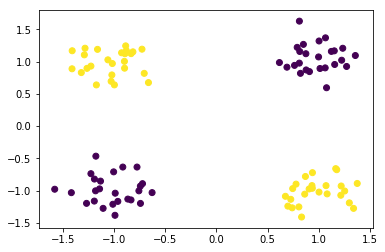

In [3]:
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])
plt.show()

## Model the classifier

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class Perceptron:
    W = None
    X = None
    Y = None
    alpha = 0.1
    
    def __init__(self, alpha):
        self.W = 1.0 - np.random.random(3) * 2.0
        self.alpha = alpha
    
    def z(this, x):
        return -(x * this.W[1] + this.W[0]) / this.W[2]
    
    def forward(this, X):
        this.X = np.copy(X)
        this.Y = sigmoid(this.X.dot(this.W))
        return np.copy(this.Y)
    
    def backward(this, upstream_grad):
        grad = upstream_grad * (1 - sigmoid(this.Y)) * sigmoid(this.Y)
        grad_W = this.X.T.dot(grad)
        next_grad = grad.reshape((grad.shape[0], 1)).dot(this.W.reshape((1, 3)))
        this.W = this.W - this.alpha * grad_W
        return next_grad

In [5]:
ones = np.ones((N, 1))
data_wo_labels = np.concatenate((ones, data[:, :2]), axis=1)

i1 = Perceptron(0.01)
i2 = Perceptron(0.01)
o = Perceptron(0.01)

def predict(X):
    H1 = i1.forward(X)
    H2 = i2.forward(X)
    combined = np.column_stack((np.ones((H1.shape[0], 1)), H1, H2))
    return o.forward(combined)

def getClass(x, th):
    return np.where(x < th, 0.0, 1.0)

Y = predict(data_wo_labels)
labels = getClass(Y, 0.5)
labels[:5]

array([0., 0., 0., 0., 0.])

### Untrained predictions and first layer classifiers

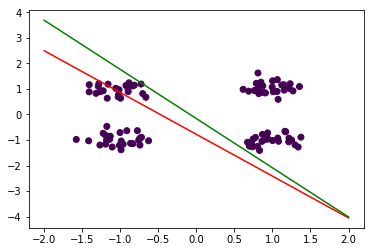

In [6]:
x = np.linspace(-2.0, 2.0)
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.plot(x, i1.z(x), color='red')
plt.plot(x, i2.z(x), color='green')

In [7]:
# Calculate mean squared error
def mean_squared_error(T, Y):
    return np.square(Y - T).mean()

# error on untrained model
mean_squared_error(data[:, 1], Y)

1.2573764310665425

## Train the model

### Split into training set and validation set

In [8]:
M = 30

X_train = np.concatenate((np.ones((N - M, 1)), data[:-M, :2]), axis=1)
T_train = data[:-M, 2]

X_test = np.concatenate((np.ones((M, 1)), data[-M:, :2]), axis=1)
T_test = data[-M:, 2]

### Plot the train and test data

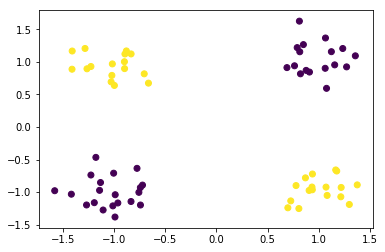

In [9]:
plt.scatter(X_train[:, 1], X_train[:, 2], c=T_train)
plt.show()

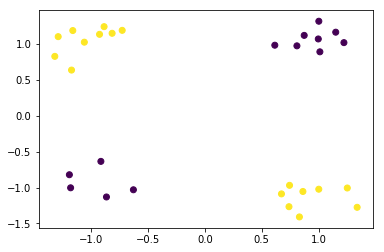

In [10]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=T_test)
plt.show()

### Gradient descent

In [11]:
def backprop(e):
    grad = o.backward(e)
    ei1 = grad[:, 1]
    ei2 = grad[:, 2]
    i1.backward(ei1)
    i2.backward(ei2)

In [12]:
# get starting error
Y_train = predict(X_train)
err_prev = mean_squared_error(T_train, Y_train)

# counter
cnt = 0

while True:
    # print error every 10 steps
    if cnt % 10000 == 0:
        print('error: ' + str(err_prev))
    cnt = cnt + 1
    
    # gradient descent
    backprop(Y_train - T_train)
    
    # re-evaluate model
    Y_train = predict(X_train)
    err = mean_squared_error(T_train, Y_train)
    err_prev = err

    # force 100000 iterations
    if cnt == 100000: break


print('final error: ' + str(err))
print('iterations: ' + str(cnt))

error: 0.25093424519292395
error: 0.23685633396574543
error: 0.19723367720504034
error: 0.3967431472686818
error: 0.0011077570151904565
error: 0.00033278882138834513
error: 0.00021702473657530996
error: 0.00018088128155938324
error: 0.0001490405449940872
error: 0.0001235542219104666
final error: 0.00010476165288530518
iterations: 100000


### Validate the model

In [13]:
Y_test = predict(X_test)
validation_err = mean_squared_error(T_test, Y_test)
validation_err

6.978404183004915e-06

### First layer classifiers

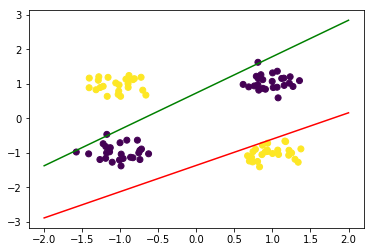

In [14]:
x = np.linspace(-2.0, 2.0)
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])
plt.plot(x, i1.z(x), color='red')
plt.plot(x, i2.z(x), color='green')

### Outputs from the first layer

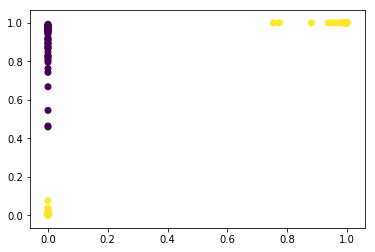

In [15]:
H1 = i1.forward(data_wo_labels)
H2 = i2.forward(data_wo_labels)

plt.scatter(H1, H2, c=data[:, 2])

### Classifier on the second layer

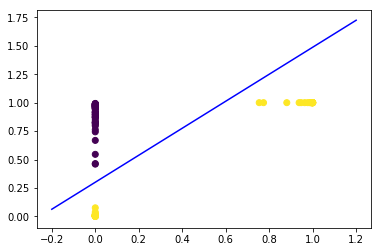

In [16]:
x = np.linspace(-0.2, 1.2)
plt.scatter(H1, H2, c=data[:, 2])
plt.plot(x, o.z(x), color='blue')

### Plot the final classification

In [17]:
Y = predict(data_wo_labels)
labels = getClass(Y, 0.5)
labels[:5]

array([1., 1., 1., 1., 1.])

On complete dataset

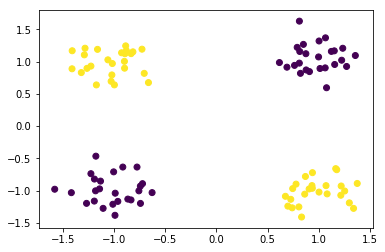

In [18]:
plt.scatter(data[:, 0], data[:, 1], c=labels)

On test data

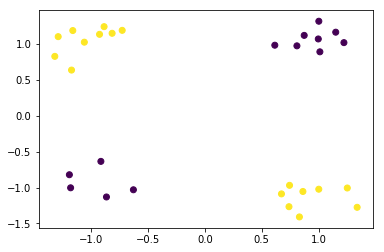

In [19]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=T_test)

## Conclusions

It is possible to classify XOR-like dataset using 3 perceptrons connected in 2 layers, however, the outcome depends greatly on the initial weights. You have to be "lucky" to start with something that second layer can work with.